# Proyecto Platzi

# Impacto de la vacunacion en la hospitalizacion COVID19-México


En este analisis, se han combinado datos sobre diferentes factores que impactan el porcentaje de ocupación hospitalaria por COVID-19 en México, como diabetes, asma, obesidad, epoc y otras conmorbilidades, el numero de casos diarios registrados y el avance diario de vacunación. A partir del conjunto de datos, podemos recopilar información sobre los patrones que nos permiten identificar los factores de los dias con tasas de ocupación hospitalaria alta por COVID-19, permitiendonos ajustar un modelo de predicción que nos permite tener una mejor respuesta a futuro.

# Hipotesis
- Impacto de los casos con conmorbilidades en el porcentaje de ocupación hospitalaria
- La vacunación contra COVID-19 ha apoyado en la reducción de casos diarios detectados
- La vacunación contra COVID-19 ha apoyado en la reducción del porcentaje de ocupación hospitalaria


# Objetivo
- Predecir el porcentaje de ocuación hospitalaria por COVID-19

In [1]:
##Importación de librerias

import kaggle ##API para descarga de dataset
import pandas as pd ##Transformación de informacion
import pyodbc ## Conexion a base de datos
import sqlalchemy ## Escritura en base de datos
from sqlalchemy import create_engine,event ## Creacion de motor para escritura en base de datos
import seaborn as sns  ## Graficacion de datos
import statsmodels.api as sm ##Estadistica
from matplotlib import pyplot as plt ## Graficacion de datos
from sklearn.preprocessing import StandardScaler ## Estandarización de datos
import numpy as np ## Operaciones matematicas
from sklearn.model_selection import train_test_split ## Separeción de datos en train y test
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier ## modelo RandomForest
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV ## Mejores parametros para el modelo
from sklearn.metrics import confusion_matrix, accuracy_score ## Matriz de confusion y accuracy del modelo
from mlxtend.plotting import plot_confusion_matrix ## Matriz de confusion
from sklearn import metrics

# Extracción de datos

Se extrae la informacion desde base de datos SQL creada en  https://cloud.google.com/

In [2]:
## Se crea conexión a base de datos

sql_engine = create_engine(sqlalchemy.engine.url.URL('mssql+pymssql', username='sql**',
                                                     password='pas', host='104.***.**.*',
                                                     database='proyecto_platzi'))

conn = sql_engine.connect()


In [ ]:
## Se crea consulta SQL para extraer datos

data = pd.read_sql("""SELECT 
       covid.FECHA_INGRESO, covid.ID_REGISTRO, covid.SECTOR, 
       covid.ENTIDAD_UM, covid.ENTIDAD_NAC, covid.ENTIDAD_RES,
       covid.MUNICIPIO_RES,covid.INTUBADO, covid.NEUMONIA, 
       covid.EDAD,covid.EMBARAZO, covid.DIABETES, covid.EPOC, 
       covid.ASMA,covid.INMUSUPR, covid.HIPERTENSION, 
       covid.OTRA_COM, covid.CARDIOVASCULAR, covid.OBESIDAD,
       covid.RENAL_CRONICA, covid.TABAQUISMO, covid.OTRO_CASO, 
       covid.CLASIFICACION_FINAL,covid.UCI, covid.id_day_vaccinations,
       vacu.people_vaccinated,
       vacu.people_fully_vaccinated,vacu.people_vaccinated_per_hundred,
       vacu.people_fully_vaccinated_per_hundred,cat_p.DESCRIPCION as TIPO_PACIENTE,
       cat_g.DESCRIPCION as SEXO
    FROM 
       proyecto_platzi.dbo.hist_covidmx covid
    LEFT JOIN 
       proyecto_platzi.dbo.hist_vacunacionmx vacu
       ON  covid.id_day_vaccinations = vacu.id_day_vaccinations
    LEFT JOIN 
       proyecto_platzi.dbo.catalogo_genero cat_g
       ON  covid.SEXO = cat_g.CLAVE
    LEFT JOIN 
       proyecto_platzi.dbo.catalogo_tipo_paciente cat_p
       ON  covid.TIPO_PACIENTE = cat_p.CLAVE
       where covid.CLASIFICACION_FINAL = 'POSITIVO';""",conn)

In [4]:
## Se valida extracccion de datos

data.head()

,FECHA_INGRESO,ID_REGISTRO,SECTOR,ENTIDAD_UM,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,INTUBADO,NEUMONIA,EDAD,...,OTRO_CASO,CLASIFICACION_FINAL,UCI,id_day_vaccinations,people_vaccinated,people_fully_vaccinated,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,TIPO_PACIENTE,SEXO
0,2021-02-28,65974c,4.0,1.0,32.0,32.0,24.0,0.0,0.0,64.0,...,0.0,POSITIVO,2.0,67.0,1889672.0,565423.0,1.45,0.43,HOSPITALIZADO,MUJER
1,2021-02-28,6cbf41,4.0,14.0,30.0,14.0,120.0,0.0,0.0,57.0,...,1.0,POSITIVO,2.0,67.0,1889672.0,565423.0,1.45,0.43,HOSPITALIZADO,MUJER
2,2021-02-28,71e68c,4.0,14.0,16.0,14.0,101.0,0.0,0.0,42.0,...,0.0,POSITIVO,2.0,67.0,1889672.0,565423.0,1.45,0.43,HOSPITALIZADO,MUJER
3,2021-02-28,d5a8ea,10.0,9.0,16.0,9.0,2.0,0.0,1.0,41.0,...,0.0,POSITIVO,1.0,67.0,1889672.0,565423.0,1.45,0.43,HOSPITALIZADO,MUJER
4,2021-02-28,db9a56,10.0,9.0,9.0,9.0,5.0,0.0,1.0,53.0,...,0.0,POSITIVO,2.0,67.0,1889672.0,565423.0,1.45,0.43,HOSPITALIZADO,None


# Transformación de datos para analisis



Se transforman variables categoricas

In [5]:
## Se generan rangos por EDAD para tratarlos como variables categoricas independientes

def rango_edad(x):
    if x <=10:
        grupo = '< 10'
    elif x<=20:
        grupo = '10 a 19'
    elif x<=30:
        grupo = '20 a 29'
    elif x<=40:
        grupo = '30 a 39'
    elif x<=50:
        grupo = '40 a 49'
    elif x<=60:
        grupo = '50 a 59'
    elif x <=70:
        grupo = '60 a 69'
    else:
        grupo = '> 69'
    return grupo

data['rango_edad'] = data.EDAD.apply(rango_edad)

In [6]:
## Generamos  dummies de variables categoricas

data = pd.concat([data.drop(columns=['rango_edad', 'SEXO','TIPO_PACIENTE']), 
                  pd.get_dummies(data['rango_edad'], prefix='edad', prefix_sep='_', drop_first=False),
                  pd.get_dummies(data['SEXO'], prefix='GENERO',prefix_sep='_', drop_first=False),
        
                  pd.get_dummies(data['TIPO_PACIENTE'], prefix='PACIENTE', prefix_sep='_',drop_first=False),
                  
                 ], axis=1)

In [8]:
## Validamos datos creados

data.head()

,FECHA_INGRESO,ID_REGISTRO,SECTOR,ENTIDAD_UM,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,INTUBADO,NEUMONIA,EDAD,...,edad_20 a 29,edad_30 a 39,edad_40 a 49,edad_50 a 59,edad_60 a 69,edad_< 10,edad_> 69,GENERO_MUJER,PACIENTE_AMBULATORIO,PACIENTE_HOSPITALIZADO
0,2021-02-28,65974c,4.0,1.0,32.0,32.0,24.0,0.0,0.0,64.0,...,0,0,0,0,1,0,0,1,0,1
1,2021-02-28,6cbf41,4.0,14.0,30.0,14.0,120.0,0.0,0.0,57.0,...,0,0,0,1,0,0,0,1,0,1
2,2021-02-28,71e68c,4.0,14.0,16.0,14.0,101.0,0.0,0.0,42.0,...,0,0,1,0,0,0,0,1,0,1
3,2021-02-28,d5a8ea,10.0,9.0,16.0,9.0,2.0,0.0,1.0,41.0,...,0,0,1,0,0,0,0,1,0,1
4,2021-02-28,db9a56,10.0,9.0,9.0,9.0,5.0,0.0,1.0,53.0,...,0,0,0,1,0,0,0,0,0,1


Se agrupa la información por registros por dia desde el dia 1 de vacunación hasta la fecha, 
para poder observar patrones entre las variables de los casos observados y el porcentaje de hospitalización

In [9]:
## Se agrupan las columnas de factores de riesgo

factores = data[['id_day_vaccinations','INTUBADO', 'NEUMONIA','EMBARAZO', 'DIABETES', 'EPOC', 'ASMA',
       'INMUSUPR', 'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD',
       'RENAL_CRONICA', 'TABAQUISMO', 'OTRO_CASO','edad_10 a 19', 'edad_20 a 29', 'edad_30 a 39', 'edad_40 a 49',
       'edad_50 a 59', 'edad_60 a 69', 'edad_< 10', 'edad_> 69',
       'GENERO_MUJER', 'PACIENTE_HOSPITALIZADO', 'PACIENTE_AMBULATORIO']]

fact_df = factores.groupby(['id_day_vaccinations', 
                               ]).agg(sum).reset_index()

## Validamos set de datos

fact_df.head()

,id_day_vaccinations,INTUBADO,NEUMONIA,EMBARAZO,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,OTRA_COM,...,edad_20 a 29,edad_30 a 39,edad_40 a 49,edad_50 a 59,edad_60 a 69,edad_< 10,edad_> 69,GENERO_MUJER,PACIENTE_HOSPITALIZADO,PACIENTE_AMBULATORIO
0,44.0,151.0,1199.0,52.0,1205.0,91.0,201.0,58.0,1616.0,185.0,...,1956.0,1956.0,1991.0,1700.0,1057.0,132.0,779.0,5219.0,1540.0,8646.0
1,45.0,118.0,1007.0,23.0,791.0,65.0,100.0,51.0,991.0,90.0,...,871.0,974.0,995.0,920.0,625.0,75.0,565.0,2633.0,1333.0,4005.0
2,46.0,138.0,869.0,15.0,532.0,53.0,67.0,20.0,691.0,82.0,...,380.0,452.0,493.0,493.0,429.0,25.0,391.0,1303.0,1163.0,1600.0
3,47.0,147.0,1204.0,58.0,1232.0,72.0,198.0,73.0,1696.0,178.0,...,2293.0,2473.0,2280.0,1918.0,1107.0,135.0,778.0,5810.0,1543.0,10102.0
4,48.0,163.0,1080.0,51.0,1033.0,64.0,153.0,68.0,1412.0,156.0,...,1753.0,1917.0,1834.0,1468.0,948.0,120.0,689.0,4692.0,1403.0,7922.0


In [10]:
## Se agrupan las columnas de factores de riesgo

vacunacion = data[['id_day_vaccinations','people_vaccinated', 'people_fully_vaccinated',
       'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred']]

vacunacion_df = vacunacion.groupby(['id_day_vaccinations', 
                               ]).agg(max).reset_index()

## Validamos set de datos

vacunacion_df.head()

,id_day_vaccinations,people_vaccinated,people_fully_vaccinated,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred
0,44.0,636070.0,64246.0,0.49,0.05
1,45.0,637098.0,73100.0,0.49,0.06
2,46.0,637681.0,75836.0,0.49,0.06
3,47.0,638391.0,79429.0,0.49,0.06
4,48.0,638391.0,79429.0,0.49,0.06


In [11]:
## Se unen los dataframe obtenidos

data_analisis = pd.merge(fact_df, vacunacion_df, on='id_day_vaccinations', how='outer')

In [12]:
## Se agrupa el numero casos positivos por dia 

registros_diarios = data.groupby(['id_day_vaccinations'])[['ID_REGISTRO']].count()
registros_diarios.head()

,ID_REGISTRO
id_day_vaccinations,
44.0,10186
45.0,5338
46.0,2763
47.0,11645
48.0,9325


In [13]:
## Se unen los dataframe obtenidos

data_analisis = pd.merge(data_analisis, registros_diarios, on='id_day_vaccinations', how='outer')

## Se valida Set de datos
data_analisis.head()

,id_day_vaccinations,INTUBADO,NEUMONIA,EMBARAZO,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,OTRA_COM,...,edad_< 10,edad_> 69,GENERO_MUJER,PACIENTE_HOSPITALIZADO,PACIENTE_AMBULATORIO,people_vaccinated,people_fully_vaccinated,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,ID_REGISTRO
0,44.0,151.0,1199.0,52.0,1205.0,91.0,201.0,58.0,1616.0,185.0,...,132.0,779.0,5219.0,1540.0,8646.0,636070.0,64246.0,0.49,0.05,10186
1,45.0,118.0,1007.0,23.0,791.0,65.0,100.0,51.0,991.0,90.0,...,75.0,565.0,2633.0,1333.0,4005.0,637098.0,73100.0,0.49,0.06,5338
2,46.0,138.0,869.0,15.0,532.0,53.0,67.0,20.0,691.0,82.0,...,25.0,391.0,1303.0,1163.0,1600.0,637681.0,75836.0,0.49,0.06,2763
3,47.0,147.0,1204.0,58.0,1232.0,72.0,198.0,73.0,1696.0,178.0,...,135.0,778.0,5810.0,1543.0,10102.0,638391.0,79429.0,0.49,0.06,11645
4,48.0,163.0,1080.0,51.0,1033.0,64.0,153.0,68.0,1412.0,156.0,...,120.0,689.0,4692.0,1403.0,7922.0,638391.0,79429.0,0.49,0.06,9325


Obtenemos los datos en forma porcentual para darnos un mejor entendiemiento de ellos

In [57]:
ID_REGISTROS = pd.Series(data_analisis.ID_REGISTRO.values) 

variables_porc = data_analisis[['INTUBADO', 'NEUMONIA', 'EMBARAZO', 'DIABETES',
                                'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
                                'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
                                'OTRO_CASO', 'edad_10 a 19', 'edad_20 a 29', 'edad_30 a 39',
                                'edad_40 a 49', 'edad_50 a 59', 'edad_60 a 69', 'edad_< 10',
                                'edad_> 69', 'GENERO_MUJER',  'PACIENTE_HOSPITALIZADO', 'PACIENTE_AMBULATORIO']]

variables_int = data_analisis[['id_day_vaccinations','people_vaccinated', 'people_fully_vaccinated',
                               'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred',
                               'ID_REGISTRO']]
variables_int['index'] = variables_int.index
variables_porc = variables_porc.div(ID_REGISTROS, axis = 0) *100
variables_porc['index'] = variables_porc.index
data_analisis_porc = pd.merge(variables_porc,variables_int, on='index', how='outer')

data_analisis_porc.head()

C:\Users\nmarin\AppData\Local\Temp/ipykernel_1624/1201008242.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  variables_int['index'] = variables_int.index


,INTUBADO,NEUMONIA,EMBARAZO,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,...,GENERO_MUJER,PACIENTE_HOSPITALIZADO,PACIENTE_AMBULATORIO,index,id_day_vaccinations,people_vaccinated,people_fully_vaccinated,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,ID_REGISTRO
0,1.482427,11.771058,0.510505,11.829963,0.893383,1.973297,0.569409,15.864913,1.816218,1.197722,...,51.236992,15.118790,84.881210,0,44.0,636070.0,64246.0,0.49,0.05,10186
1,2.210566,18.864743,0.430873,14.818284,1.217685,1.873361,0.955414,18.565006,1.686025,1.461221,...,49.325590,24.971900,75.028100,1,45.0,637098.0,73100.0,0.49,0.06,5338
2,4.994571,31.451321,0.542888,19.254434,1.918205,2.424900,0.723851,25.009048,2.967789,1.954397,...,47.158885,42.091929,57.908071,2,46.0,637681.0,75836.0,0.49,0.06,2763
3,1.262344,10.339201,0.498068,10.579648,0.618291,1.700301,0.626878,14.564191,1.528553,1.056247,...,49.892658,13.250322,86.749678,3,47.0,638391.0,79429.0,0.49,0.06,11645
4,1.747989,11.581769,0.546917,11.077748,0.686327,1.640751,0.729223,15.142091,1.672922,1.179625,...,50.316354,15.045576,84.954424,4,48.0,638391.0,79429.0,0.49,0.06,9325


# Hipotesis

- La vacunación contra COVID-19 ha apoyado en la reducción de casos diarios detectados
- La vacunación contra COVID-19 ha apoyado en la reducción del porcentaje de ocupación hospitalaria



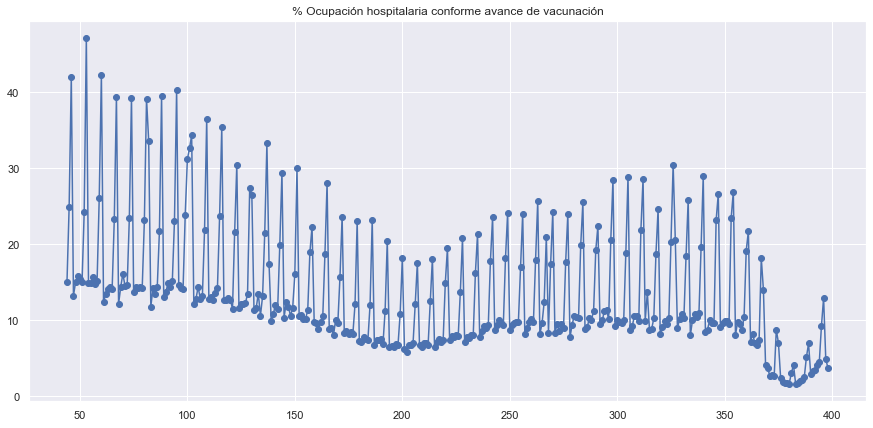

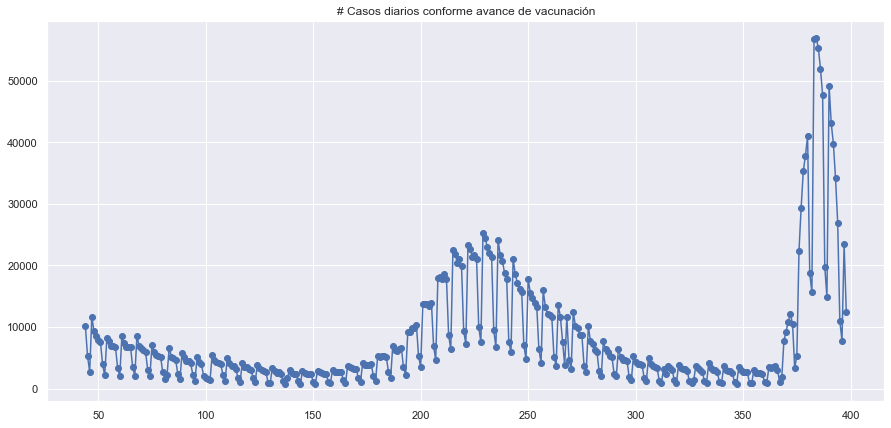

In [448]:
x=data_analisis_porc['id_day_vaccinations']
y=data_analisis_porc['PACIENTE_HOSPITALIZADO']

plt.plot(x,y,marker="o",label=True)
plt.gcf().set_size_inches(15, 7)
plt.title("% Ocupación hospitalaria conforme avance de vacunación")
plt.show()

x=data_analisis_porc['id_day_vaccinations']
y=data_analisis_porc['ID_REGISTRO']

plt.plot(x,y,marker="o",label=True)
plt.gcf().set_size_inches(15, 7)
plt.title("# Casos diarios conforme avance de vacunación")
plt.show()



# Comprobación de hipotesis

El analisis nos permite obtener una vista clara del comportamiento del % de hospitalización transcurridos los dias de vacunación

- La vacunación contra COVID-19 si ha tenido un imparto importante en la reducción de % de ocupación hospitalaria
- La vacunación contra COVID-19 no ayuda en la reducción de menos casos, incluso se observan picos en las ultimas fechas de vacunación

# Hipotesis
- Impacto de los casos con conmorbilidades en el porcentaje de ocupación hospitalaria

El porcentaje de hospotalización si está relacionado con los casos de conmorbilidad

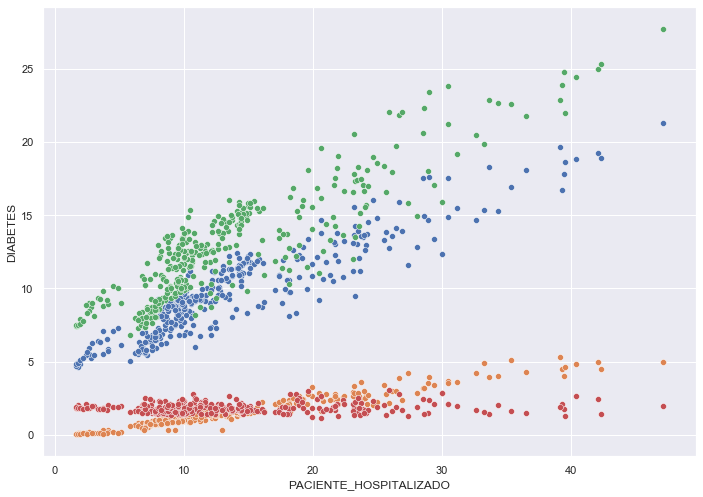

In [459]:
## Obsevamos distribucion de variables
sns.scatterplot(  data=data_analisis_porc, x="PACIENTE_HOSPITALIZADO", y='DIABETES', )
sns.scatterplot(  data=data_analisis_porc, x="PACIENTE_HOSPITALIZADO", y='INTUBADO', )
sns.scatterplot(  data=data_analisis_porc, x="PACIENTE_HOSPITALIZADO", y='HIPERTENSION', )
sns.scatterplot(  data=data_analisis_porc, x="PACIENTE_HOSPITALIZADO", y='ASMA', )

In [58]:
data_analisis_porc.columns

Index(['INTUBADO', 'NEUMONIA', 'EMBARAZO', 'DIABETES', 'EPOC', 'ASMA',
       'INMUSUPR', 'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD',
       'RENAL_CRONICA', 'TABAQUISMO', 'OTRO_CASO', 'edad_10 a 19',
       'edad_20 a 29', 'edad_30 a 39', 'edad_40 a 49', 'edad_50 a 59',
       'edad_60 a 69', 'edad_< 10', 'edad_> 69', 'GENERO_MUJER',
       'PACIENTE_HOSPITALIZADO', 'PACIENTE_AMBULATORIO', 'index',
       'id_day_vaccinations', 'people_vaccinated', 'people_fully_vaccinated',
       'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred',
       'ID_REGISTRO'],
      dtype='object')

# Predicción de % de ocupación hospitalaria

# Crear modelo - Random Forests Classifiers

Se utiliza un RandomForestClassifier ya que por las variables utilizadas nos permite evitar un sobreajustamiento del modelo y obtener una vista de la importancia relativa de cada una de las variables que utilizamos.


Hacemos las primeras transformaciones para preparar el set de datos e iniciar a ajustar el modelo

Realizamos la separación de datos utilizando el .2 para test y el resto ara entrenamiento del modelo.

Definimos como nuestra variable dependiente y el porcentaje de hospitalización diaria



In [385]:
y = data_analisis_porc['PACIENTE_HOSPITALIZADO']
X = data_analisis_porc.drop(columns=['PACIENTE_HOSPITALIZADO','PACIENTE_AMBULATORIO','index'])

In [386]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

Utilizamos StandardScaler para estandarizar nuestras variables buscando un valor medio de 0 y una desviación estándar de 1.

In [387]:
scaler = StandardScaler()

In [388]:
X_train = pd.concat([X_train.drop(columns=[ 'INTUBADO','NEUMONIA', 'EMBARAZO', 'DIABETES', 'EPOC', 'ASMA',
       'INMUSUPR', 'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD',
       'RENAL_CRONICA', 'TABAQUISMO', 'OTRO_CASO', 'edad_10 a 19',
       'edad_20 a 29', 'edad_30 a 39', 'edad_40 a 49', 'edad_50 a 59',
       'edad_60 a 69', 'edad_< 10', 'edad_> 69', 'GENERO_MUJER',
       'id_day_vaccinations', 'people_vaccinated', 'people_fully_vaccinated',
       'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred',
       'ID_REGISTRO']),
                     pd.DataFrame(scaler.fit_transform(X_train[['INTUBADO','NEUMONIA', 'EMBARAZO', 'DIABETES', 'EPOC', 'ASMA',
       'INMUSUPR', 'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD',
       'RENAL_CRONICA', 'TABAQUISMO', 'OTRO_CASO', 'edad_10 a 19',
       'edad_20 a 29', 'edad_30 a 39', 'edad_40 a 49', 'edad_50 a 59',
       'edad_60 a 69', 'edad_< 10', 'edad_> 69', 'GENERO_MUJER',
       'id_day_vaccinations', 'people_vaccinated', 'people_fully_vaccinated',
       'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred',
       'ID_REGISTRO']]),
                                  columns=[ 'INTUBADO','NEUMONIA', 'EMBARAZO', 'DIABETES', 'EPOC', 'ASMA',
       'INMUSUPR', 'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD',
       'RENAL_CRONICA', 'TABAQUISMO', 'OTRO_CASO', 'edad_10 a 19',
       'edad_20 a 29', 'edad_30 a 39', 'edad_40 a 49', 'edad_50 a 59',
       'edad_60 a 69', 'edad_< 10', 'edad_> 69', 'GENERO_MUJER',
       'id_day_vaccinations', 'people_vaccinated', 'people_fully_vaccinated',
       'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred',
       'ID_REGISTRO'],
                                  index = X_train.index
                                 )], axis=1)

In [389]:
X_train.head()

,INTUBADO,NEUMONIA,EMBARAZO,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,...,edad_60 a 69,edad_< 10,edad_> 69,GENERO_MUJER,id_day_vaccinations,people_vaccinated,people_fully_vaccinated,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,ID_REGISTRO
186,-0.708921,-0.783769,-0.260236,-0.944399,-0.823584,-1.183819,-0.875772,-1.186729,-0.990437,-0.901942,...,-0.707392,-0.055486,-0.879498,-0.891947,0.079531,0.252860,-0.164875,0.252900,-0.165078,1.950027
353,-1.480168,-1.354296,2.348090,-0.814843,-0.702911,0.112870,-0.066083,-0.772511,-1.353630,-0.505372,...,-0.731759,-0.320903,-0.835255,2.236150,1.716690,1.364094,1.759176,1.364030,1.758759,1.837124
88,-0.073875,-0.225848,-0.007674,-0.375648,-0.491591,0.272943,0.023319,-0.386806,-0.022659,-0.490620,...,-0.966797,-0.854147,-0.812531,0.505624,-0.881197,-1.058403,-0.913348,-1.058295,-0.913464,-0.544139
138,-0.580190,-0.748093,-0.273572,-1.267731,-1.410820,-0.204785,-1.336999,-1.006754,-0.916289,-1.368826,...,-1.415473,-0.765887,-1.236366,-0.431281,-0.391029,-0.503442,-0.537310,-0.503403,-0.537483,-0.267485
56,2.138488,2.719414,-1.452031,1.974158,2.086377,0.405574,1.020998,1.701890,1.652515,1.644422,...,1.335007,-1.024902,2.130316,-0.537657,-1.194904,-1.244298,-1.202007,-1.244455,-1.202090,-0.681427


Separamos nuestra variable y en cuartiles para determinar nuestras clases objetivo

- 0 - Nivel de ocupación hospitalaria baja
- 1 - Nivel de ocupación hospitalaria media 
- 2 - Nivel de ocupación hospitalaria alta
- 3 - Nivel de ocupación hospitalaria muy alta

In [390]:
median = y_train.median()
Q1 = y_train.quantile(q=0.25)
Q3 = y_train.quantile(q=0.75)
min_val = y_train.quantile(q=0)
max_val = y_train.quantile(q=1.0)
print(min_val, Q1, median, Q3, max_val)

1.636337988432783 8.790916753139772 11.294497055166099 17.506277027592663 47.161975080756804


In [391]:

y_train = pd.cut(y_train, bins=[1.63,8.7, 11.29,17.50, 100.00], labels= ['0','1','2','3'])

Realizamos las mismas transformaciones para nuestros datos de prueba

In [392]:
X_test = pd.concat([X_test.drop(columns=['INTUBADO', 'NEUMONIA', 'EMBARAZO', 'DIABETES', 'EPOC', 'ASMA',
       'INMUSUPR', 'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD',
       'RENAL_CRONICA', 'TABAQUISMO', 'OTRO_CASO', 'edad_10 a 19',
       'edad_20 a 29', 'edad_30 a 39', 'edad_40 a 49', 'edad_50 a 59',
       'edad_60 a 69', 'edad_< 10', 'edad_> 69', 'GENERO_MUJER',
       'id_day_vaccinations', 'people_vaccinated', 'people_fully_vaccinated',
       'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred',
       'ID_REGISTRO']),
                    pd.DataFrame(scaler.transform(X_test[['INTUBADO','NEUMONIA', 'EMBARAZO', 'DIABETES', 'EPOC', 'ASMA',
       'INMUSUPR', 'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD',
       'RENAL_CRONICA', 'TABAQUISMO', 'OTRO_CASO', 'edad_10 a 19',
       'edad_20 a 29', 'edad_30 a 39', 'edad_40 a 49', 'edad_50 a 59',
       'edad_60 a 69', 'edad_< 10', 'edad_> 69', 'GENERO_MUJER',
       'id_day_vaccinations', 'people_vaccinated', 'people_fully_vaccinated',
       'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred',
       'ID_REGISTRO']]),
                                 columns=['INTUBADO','NEUMONIA', 'EMBARAZO', 'DIABETES', 'EPOC', 'ASMA',
       'INMUSUPR', 'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD',
       'RENAL_CRONICA', 'TABAQUISMO', 'OTRO_CASO', 'edad_10 a 19',
       'edad_20 a 29', 'edad_30 a 39', 'edad_40 a 49', 'edad_50 a 59',
       'edad_60 a 69', 'edad_< 10', 'edad_> 69', 'GENERO_MUJER',
       'id_day_vaccinations', 'people_vaccinated', 'people_fully_vaccinated',
       'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred',
       'ID_REGISTRO'],
                                 index = X_test.index
                                )], axis=1)

In [393]:
y_test = pd.cut(y_test, bins=[1.63,8.7, 11.29,17.50, 100.00], labels= ['0','1','2','3'])

Se definen parametros del modelo, se definen class_weight='balanced', random_state=42, min_samples_leaf=5 y mantienen los parametros por defecto

In [394]:
rfclf = RandomForestClassifier(class_weight='balanced', random_state=42, min_samples_leaf=5)
ovr_rfclf = OneVsRestClassifier(rfclf)

In [395]:
ovr_rfclf.get_params()

{'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': 'balanced',
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': 'auto',
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 5,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': 42,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_l

Utilizamos el metodo GridSearchCV para obtener los mejores parametros para nuestro modelo

In [396]:
gridparams = {'estimator__n_estimators': [i for i in range (50, 105, 10)],
              'estimator__max_depth': [i for i in range (20, 40, 3)]
             }

In [397]:
cmodel = GridSearchCV(ovr_rfclf, param_grid=gridparams, 
                      n_jobs=-1,
                      scoring='neg_log_loss', cv=5)

Realizamos el entrenamiento del modelo

In [398]:
cmodel.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                                            ccp_alpha=0.0,
                                                                            class_weight='balanced',
                                                                            criterion='gini',
                                                                            max_depth=None,
                                                                            max_features='auto',
                                                                            max_leaf_nodes=None,
                                                                            max_samples=None,
                                                                            min_impurity_decrease=0.0,
                                                                            min_impurity_split=None,
  

Interpretación de accuracy y matriz de confusion

Validamos la eficacia del modelo
- Se obtiene un 0.96 % general

- el 96 % de nuestros datos fueron estimados de acuerdo a lo esperado

- Solo el 2.11 % de nuestros datos obtuvieron un resultado (Faldo positivo) no tuvierón el nivel de hospitalización esperado por el modelo

- Y solo el 1.89 % de nuestros datos obtuvieron un resultado mayor a lo esperado por el modelo






              precision    recall  f1-score   support

           0     0.9844    0.9403    0.9618        67
           1     0.9241    0.9733    0.9481        75
           2     0.9855    0.9577    0.9714        71
           3     0.9861    1.0000    0.9930        71

    accuracy                         0.9683       284
   macro avg     0.9700    0.9678    0.9686       284
weighted avg     0.9692    0.9683    0.9684       284



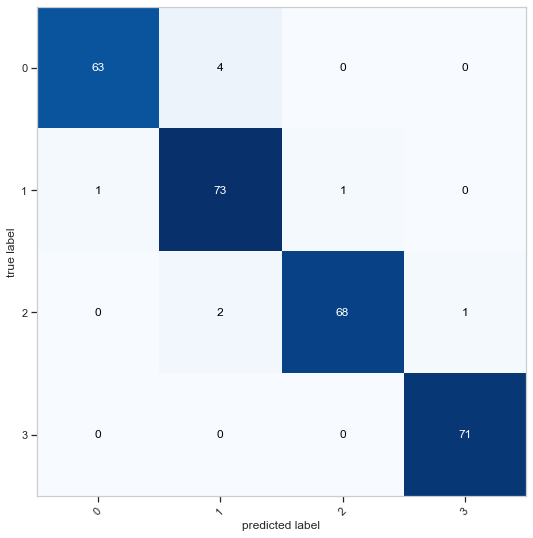

In [400]:
matc = confusion_matrix(y_train, cmodel.predict(X_train))
names = ['0','1','2','3']
plot_confusion_matrix(conf_mat=matc,figsize=(9,9), class_names = names, show_normed =False)
print(metrics.classification_report(y_train,cmodel.predict(X_train),digits =4))

In [371]:
accuracy_score(y_train, cmodel.predict(X_train))

0.9607843137254902

Validamos el accuracy con nuestros datos de test y obtemos el 96.15 % de eficacia

In [373]:
accuracy_score(y_test, cmodel.predict(X_test))

0.9615384615384616

Obtenemos la inportancia de cada una de nuestras variables para el modelo 

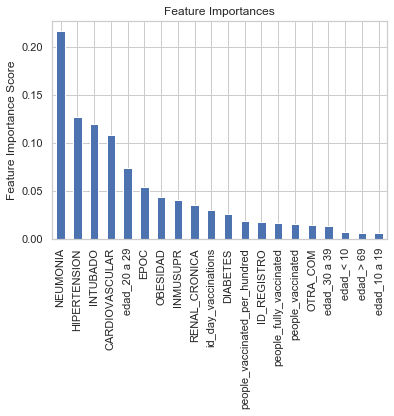

In [376]:
feat_imp = pd.Series(ovr_rfclf_def.estimators_[0].feature_importances_, X_train.columns).sort_values(ascending=False)
feat_imp = feat_imp.iloc[:20]
sns.set_style(style='whitegrid')
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()

In [405]:
datos_predic = X_train.copy()
datos_predic['predict'] = ovr_rfclf_def.predict(X_train)
datos_predic['real'] = y_train

In [406]:
datos_predic.head()

,INTUBADO,NEUMONIA,EMBARAZO,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,...,edad_> 69,GENERO_MUJER,id_day_vaccinations,people_vaccinated,people_fully_vaccinated,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,ID_REGISTRO,predict,real
186,-0.708921,-0.783769,-0.260236,-0.944399,-0.823584,-1.183819,-0.875772,-1.186729,-0.990437,-0.901942,...,-0.879498,-0.891947,0.079531,0.252860,-0.164875,0.252900,-0.165078,1.950027,0,0
353,-1.480168,-1.354296,2.348090,-0.814843,-0.702911,0.112870,-0.066083,-0.772511,-1.353630,-0.505372,...,-0.835255,2.236150,1.716690,1.364094,1.759176,1.364030,1.758759,1.837124,0,0
88,-0.073875,-0.225848,-0.007674,-0.375648,-0.491591,0.272943,0.023319,-0.386806,-0.022659,-0.490620,...,-0.812531,0.505624,-0.881197,-1.058403,-0.913348,-1.058295,-0.913464,-0.544139,2,2
138,-0.580190,-0.748093,-0.273572,-1.267731,-1.410820,-0.204785,-1.336999,-1.006754,-0.916289,-1.368826,...,-1.236366,-0.431281,-0.391029,-0.503442,-0.537310,-0.503403,-0.537483,-0.267485,0,0
56,2.138488,2.719414,-1.452031,1.974158,2.086377,0.405574,1.020998,1.701890,1.652515,1.644422,...,2.130316,-0.537657,-1.194904,-1.244298,-1.202007,-1.244455,-1.202090,-0.681427,3,3


## hallazgos

Validacion de hipotesis

Hipotesis

- La vacunación contra COVID-19 ha apoyado en la reducción de casos diarios detectados

- La vacunación contra COVID-19 ha apoyado en la reducción del porcentaje de ocupación hospitalaria

El analisis nos permite obtener una vista clara del comportamiento del % de hospitalización transcurridos los dias de vacunación

- La vacunación contra COVID-19 si ha tenido un imparto importante en la reducción de % de ocupación hospitalaria
- La vacunación contra COVID-19 no ayuda en la reducción de menos casos, incluso se observan picos en las ultimas fechas de vacunación


Predicción de casos 

Es posible realizar una prediccón precisa de % de ocupación hospitalaria